In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../datasets/train_features_water.csv')
df_labels = pd.read_csv('../datasets/train_labels_water.csv')

## Explore the data

In this section, we should check for duplicates, need for imputation, any additional columns we'd like to create, normalization & standardization.

In [11]:
df.shape

(59400, 40)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

In [6]:
total_nulls = df.isnull().sum()
total_obs = df.shape[0]

null_p = total_nulls[total_nulls > 0] / total_obs * 100
total_nulls = total_nulls[total_nulls > 0]

pd.concat([total_nulls, null_p], axis=1, keys=['Total', 'Percentage']).sort_values(by='Total', ascending=False)

,Total,Percentage
scheme_name,28166,47.417508
scheme_management,3877,6.526936
installer,3655,6.153199
funder,3635,6.119529
public_meeting,3334,5.612795
permit,3056,5.144781
subvillage,371,0.624579


**Additional Columns**

     - Broader Region (N, S, W, E, NW, ...)
     - We should also maybe bin the construction years (every 2-5 years maybe)
     - Perhaps look into amount_tsh, see if we can do something with that...
    

    - scheme_name has too many missing values to be useful, we should drop this column.
    - scheme_management - this is a useful column so we shouldn't drop it, we could either replace all missing values with 'Other', (as we will likely have to do that anyway)
    - installer - same as scheme_management
    - funder - same as scheme_management
    - public_meeting - TODO: Find out what this column means....
    - permit - TODO: Find out what this column means...
    - subvillage we can impute based off other geographical data, perhaps using clustering.

In [6]:
df.nunique(axis=0)

id                       59400
amount_tsh                  98
date_recorded              356
funder                    1897
gps_height                2428
installer                 2145
longitude                57516
latitude                 57517
wpt_name                 37400
num_private                 65
basin                        9
subvillage               19287
region                      21
region_code                 27
district_code               20
lga                        125
ward                      2092
population                1049
public_meeting               2
recorded_by                  1
scheme_management           12
scheme_name               2696
permit                       2
construction_year           55
extraction_type             18
extraction_type_group       13
extraction_type_class        7
management                  12
management_group             5
payment                      7
payment_type                 7
water_quality                8
quality_

In [12]:
df.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


amount_tsh (total vertical distance pump carries the water from source to tap (m))

    - max value of 350000 seems excessively high, we should look into that
    - especially when the max gps height is only 2770m (gps height is height of pump from sea-level).
   

population

    - why is min & 25% = 0, what does this mean - is this an error or is there actually no people in these areas

construction_year

    - a lot of 0 values, we will definitely need to impute this, perhaps based off waterpoint type/district rather than the mean (although we can try both).

In [201]:
# percent of data that has construction year 0

df.loc[df['construction_year'] == 0].shape[0] / df['construction_year'].shape[0]

0.34863636363636363

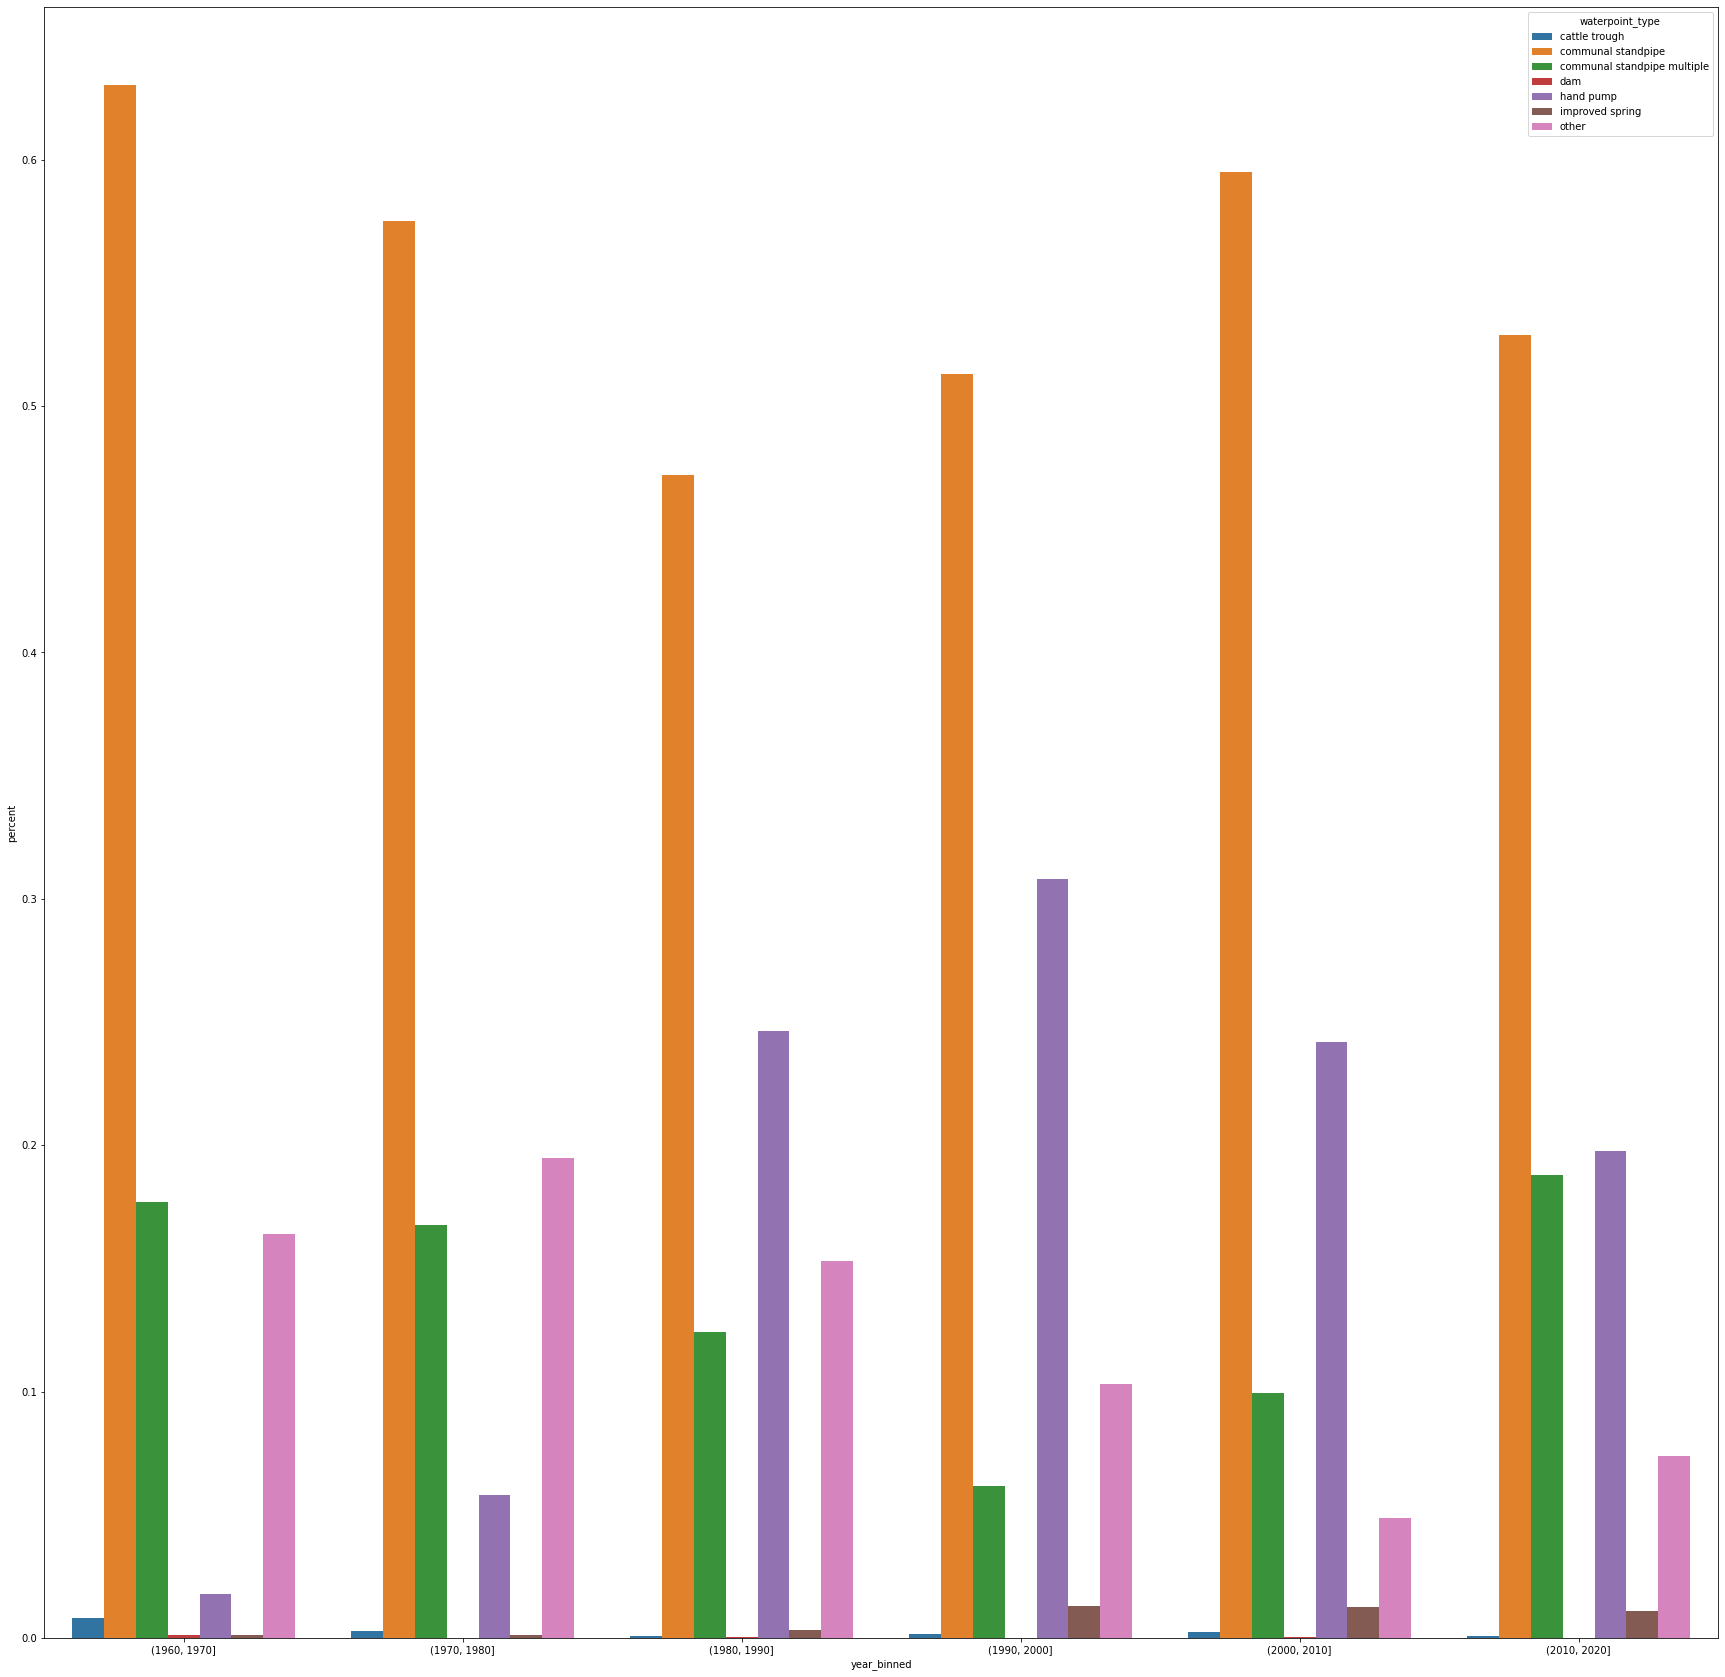

In [118]:
# let's just drop the 0s for now

df_test = df.copy()
df_test = df_test[df_test['construction_year'] != 0]

bins = [1960, 1970, 1980, 1990, 2000, 2010, 2020]
df_test['year_binned'] = pd.cut(df['construction_year'], bins)

df_gby = df_test.groupby(['year_binned', 'waterpoint_type']).agg('size').reset_index(name='counts')
df_gby['percent'] = df_gby.groupby('year_binned')['counts'].transform(lambda x: x/sum(x))

fig, axs = plt.subplots(figsize=(30, 30))
sns.barplot(data=df_gby, x="year_binned", y='percent', hue='waterpoint_type')
plt.show()

There doesn't seem to be much correlation between the waterpoint_type and construction year. There are two points:

    - 'other' usage goes down as time progresses
    - 'hand pump' usage goes up as time progresses

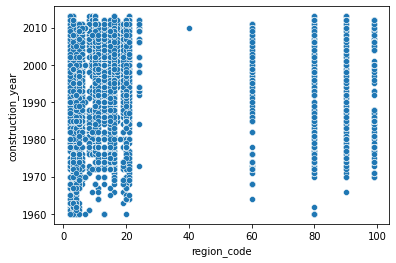

In [123]:
# We need to look some other correlations

sns.scatterplot(df_test, x='region_code', y='construction_year')
plt.show()

No correlation between construction_year and region

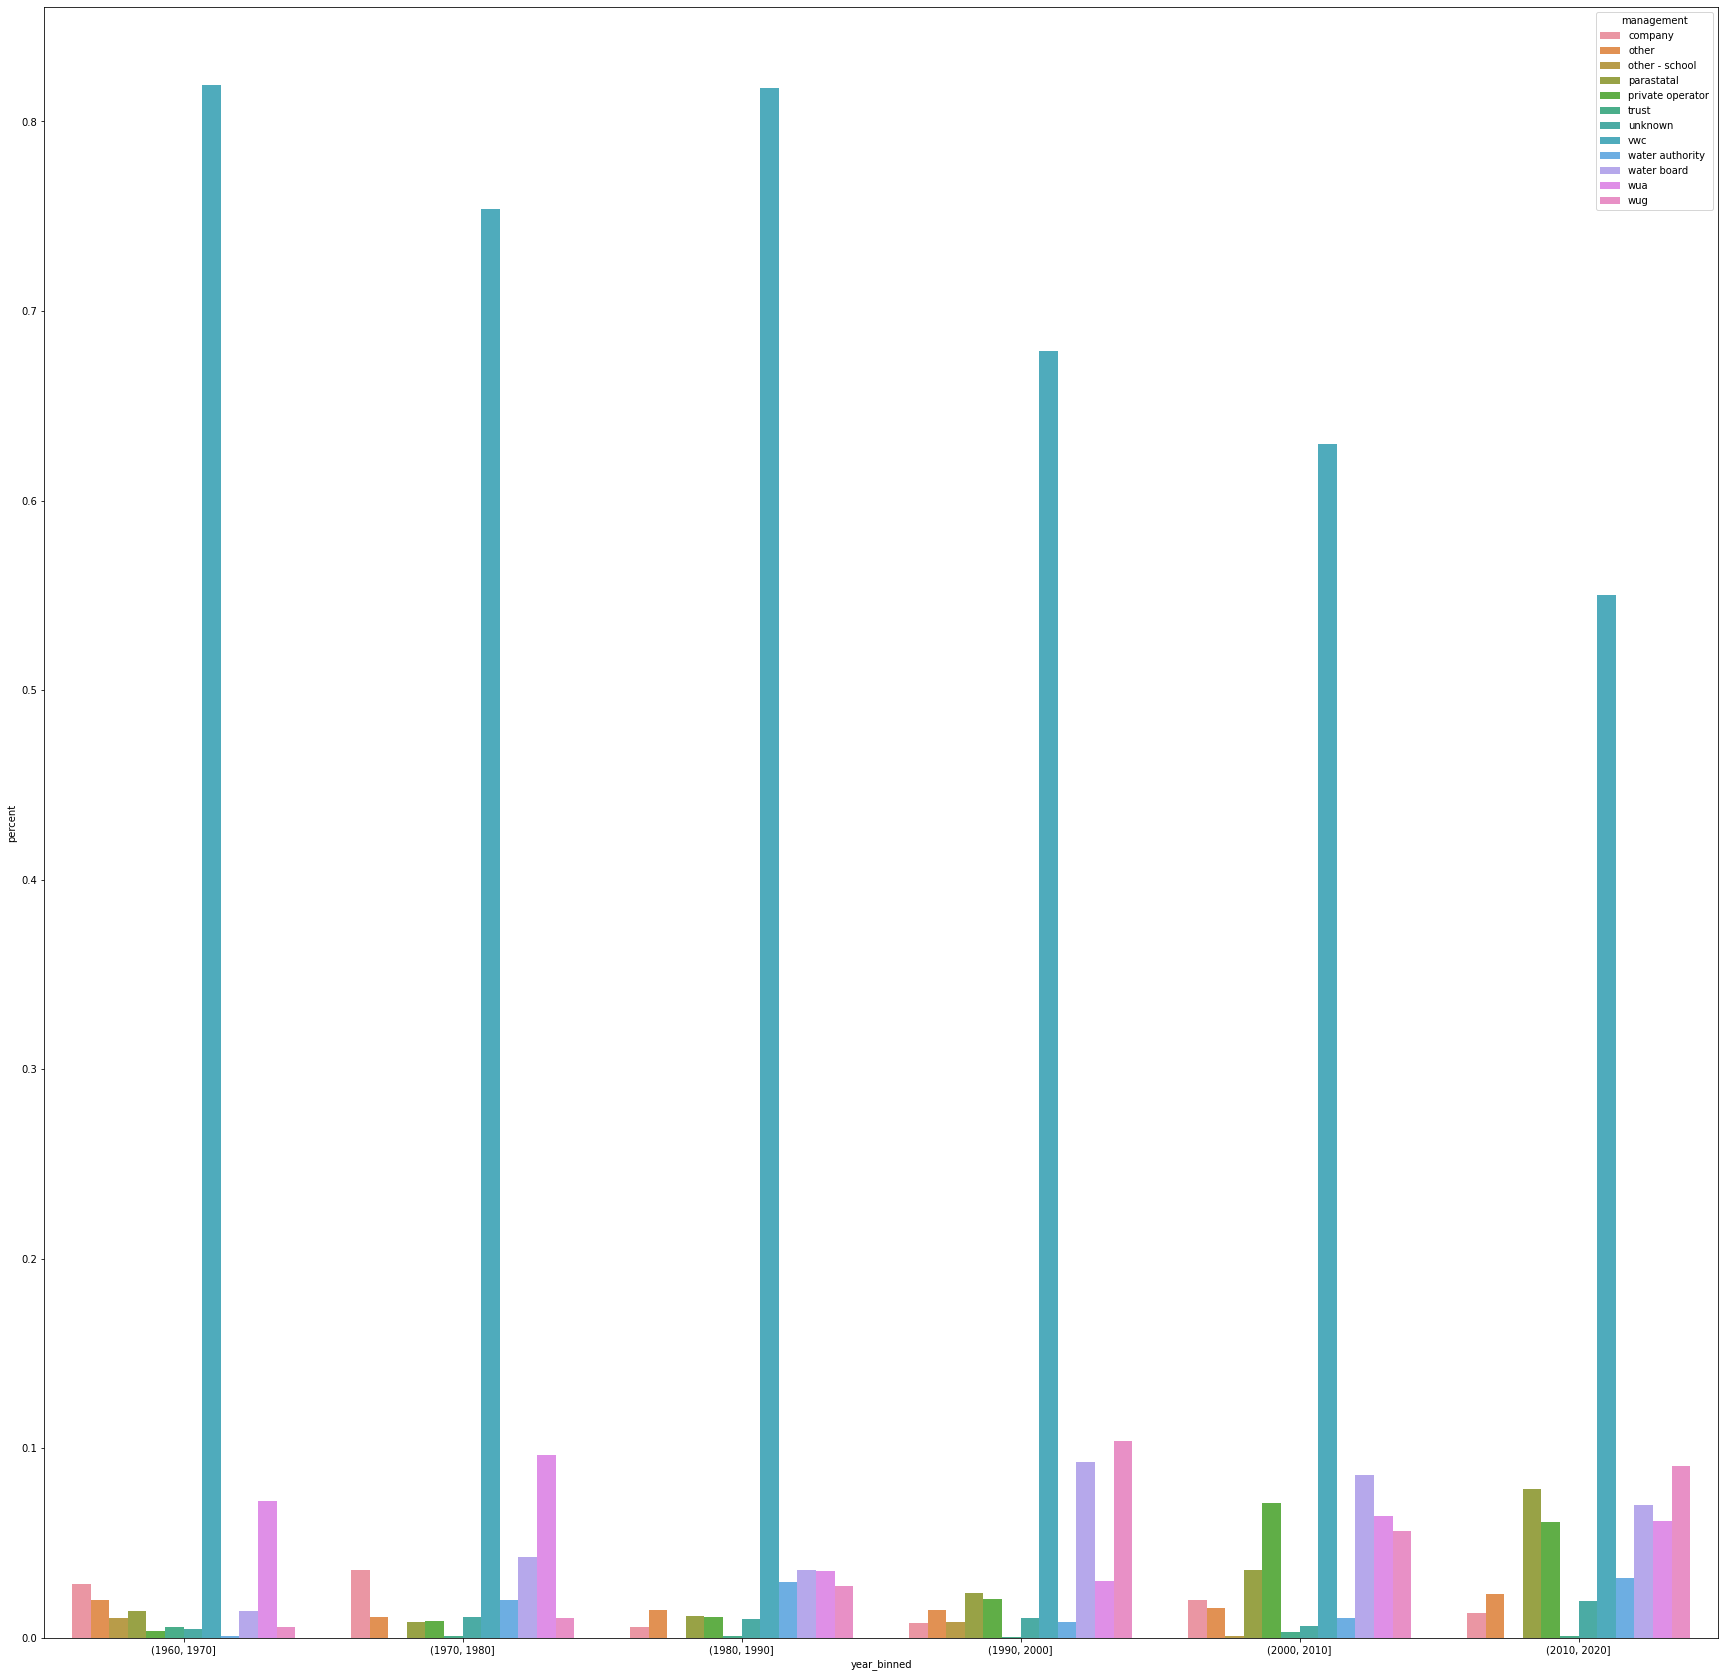

In [129]:
df_gby = df_test.groupby(['year_binned', 'management']).agg('size').reset_index(name='counts')
df_gby['percent'] = df_gby.groupby('year_binned')['counts'].transform(lambda x: x/sum(x))

fig, axs = plt.subplots(figsize=(30, 30))
sns.barplot(data=df_gby, x="year_binned", y='percent', hue='management')
plt.show()

Interesting point here, 'parastatal' and 'private' definitely go up in percentage installed as the years increase.

In [190]:
df_years = df_test.groupby('construction_year').size().reset_index(name='count')

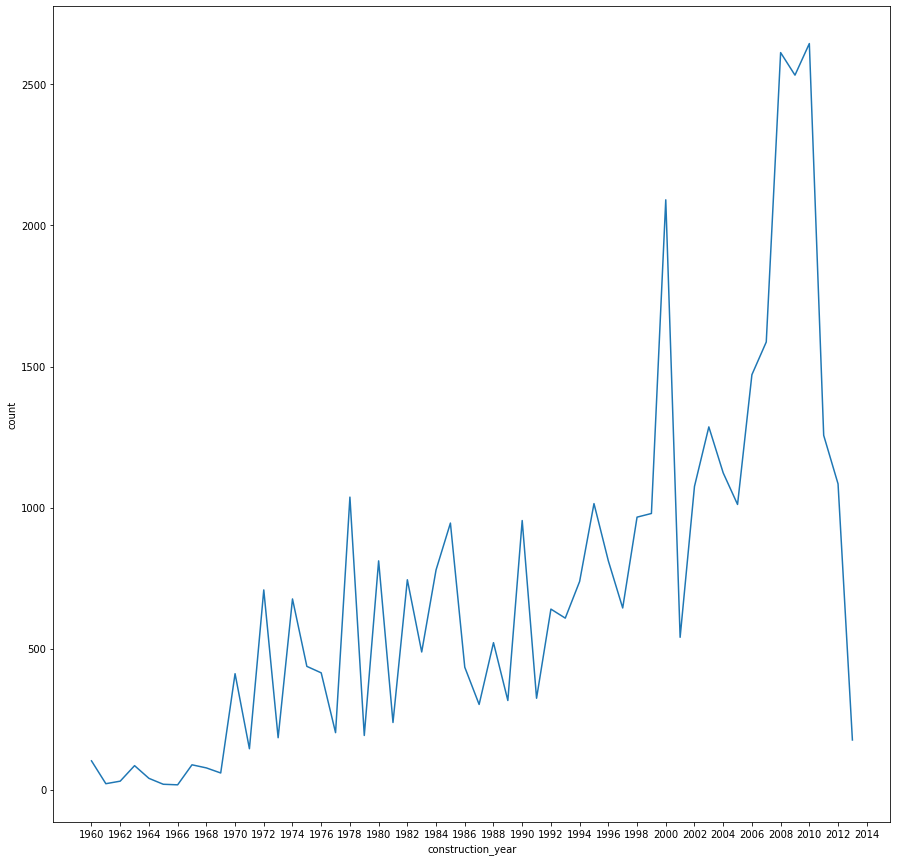

In [194]:
fig, ax = plt.subplots(figsize=(15, 15))

sns.lineplot(data=df_years, x='construction_year', y='count', ax=ax)
ax.xaxis.set_ticks(np.arange(1960, 2016, 2))
plt.show()

We could sample from this distribution? https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.sample.html

mice: https://cran.r-project.org/web/packages/miceRanger/vignettes/miceAlgorithm.html

Here are also some useful imputers from scikit-learn https://scikit-learn.org/stable/modules/impute.html